

---
# Assignment: Building a Classification Model


---



In [33]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from tabulate import tabulate

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Step 1: Data Understanding
# Load Dataset
file_path = '/content/drive/My Drive/Colab_Notebooks/RahulGandhi_comments.csv'
data = pd.read_csv(file_path)


In [4]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822 entries, 0 to 4821
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   4201 non-null   object
dtypes: object(1)
memory usage: 37.8+ KB
None
                                               tweet
0                      Sir adhiwasi sitting on floor
1  He means gandi khandan will Trample Constituti...
2                         Sir milna hai aapse please
3                          Wru your jilabe bai pusyy
4                                  Jilabe Rahul Khan


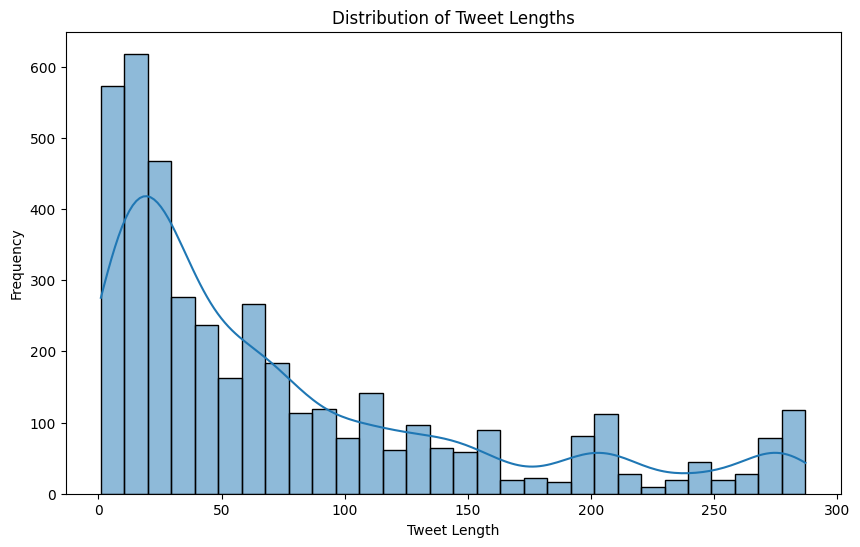

In [5]:
# Distribution of Tweet Lengths
data['tweet_length'] = data['tweet'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data['tweet_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

In [6]:
# Step 2: Data Preprocessing
# Clean text data
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', str(text))  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower().strip()
    return text

data = data.dropna(subset=['tweet'])  # Drop missing tweets
data.loc[:, 'cleaned_tweet'] = data['tweet'].apply(clean_text)
#data=data.copy()
#data['cleaned_tweet'] = data['tweet'].apply(clean_text)
data = data[data['cleaned_tweet'].str.strip() != '']  # Remove empty strings

In [7]:
# Define keywords for topics
topic_keywords = {
    'Healthcare': ['health', 'hospital', 'doctor', 'medicine', 'disease'],
    'Economy': ['economy', 'money', 'finance', 'tax', 'budget'],
    'Education': ['school', 'education', 'college', 'university', 'students'],
    'Politics': ['election', 'government', 'policy', 'vote', 'leader'],
}

def label_topic(text):
    for topic, keywords in topic_keywords.items():
        if any(word in text for word in keywords):
            return topic
    return 'Other'

# Define keywords for sentiments
def label_sentiment(text):
    positive_keywords = ['good', 'great', 'love', 'happy', 'excellent', 'awesome']
    negative_keywords = ['bad', 'hate', 'angry', 'sad', 'terrible', 'horrible']
    neutral_keywords = ['okay', 'fine', 'neutral', 'meh', 'average']

    if any(word in text for word in positive_keywords):
        return 'Positive'
    elif any(word in text for word in negative_keywords):
        return 'Negative'
    elif any(word in text for word in neutral_keywords):
        return 'Neutral'
    else:
        return 'Neutral'

In [8]:
# Apply labeling functions
data['topic'] = data['cleaned_tweet'].apply(label_topic)
data['sentiment'] = data['cleaned_tweet'].apply(label_sentiment)

# Remove rows with 'Other' topic for simplicity
data = data[data['topic'] != 'Other']

print("Data After Preprocessing:")
print(data[['cleaned_tweet', 'topic', 'sentiment']].head())

Data After Preprocessing:
                                        cleaned_tweet     topic sentiment
11     odisha also needs a leader who can revive cong  Politics   Neutral
30  bahadurpally to dullapally road conditions is ...  Politics   Neutral
60  telangana people want justice we voted just fo...   Economy   Neutral
61  how many people your govt make homeless which ...  Politics   Neutral
68    congresshataodeshbachao toiletseattax toilettax   Economy   Neutral


<ipython-input-8-840c4c056c9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['topic'] = data['cleaned_tweet'].apply(label_topic)


In [11]:
#Top 10 Frequent Words in Each Sentiment and Topic Category
def get_top_words_for_category(category, label_column):
    words = ' '.join(data[data[label_column] == category]['cleaned_tweet']).split()
    word_counts = Counter(words)
    return word_counts.most_common(10)

# Top words for sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    print(f"Top 10 Words for {sentiment} sentiment:")
    print(get_top_words_for_category(sentiment, 'sentiment'))

# Top words for topic
for topic in ['Healthcare', 'Economy', 'Education', 'Other']:
    print(f"Top 10 Words for {topic} topic:")
    print(get_top_words_for_category(topic, 'topic'))

Top 10 Words for Positive sentiment:
[('the', 8), ('to', 7), ('leader', 7), ('and', 6), ('great', 5), ('of', 5), ('a', 4), ('this', 4), ('country', 3), ('indian', 3)]
Top 10 Words for Negative sentiment:
[('jay', 14), ('congress', 4), ('hindustan', 4), ('ka', 3), ('jindabad', 3), ('to', 3), ('vote', 3), ('shree', 2), ('samvidhan', 2), ('voice', 2)]
Top 10 Words for Neutral sentiment:
[('the', 180), ('of', 166), ('to', 127), ('in', 113), ('congress', 112), ('a', 109), ('hai', 104), ('ka', 98), ('for', 86), ('tax', 72)]
Top 10 Words for Healthcare topic:
[('and', 4), ('make', 3), ('on', 2), ('of', 2), ('its', 2), ('the', 2), ('or', 2), ('amp', 2), ('pls', 1), ('ensure', 1)]
Top 10 Words for Economy topic:
[('ka', 96), ('tax', 72), ('toilet', 69), ('hai', 66), ('par', 64), ('himachal', 32), ('bhi', 31), ('bol', 31), ('de', 31), ('naa', 31)]
Top 10 Words for Education topic:
[('the', 95), ('to', 95), ('of', 64), ('his', 63), ('a', 61), ('education', 36), ('and', 32), ('is', 32), ('may', 31

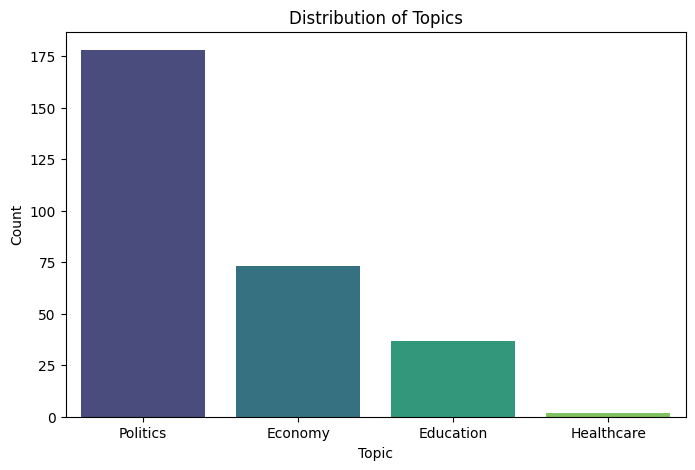

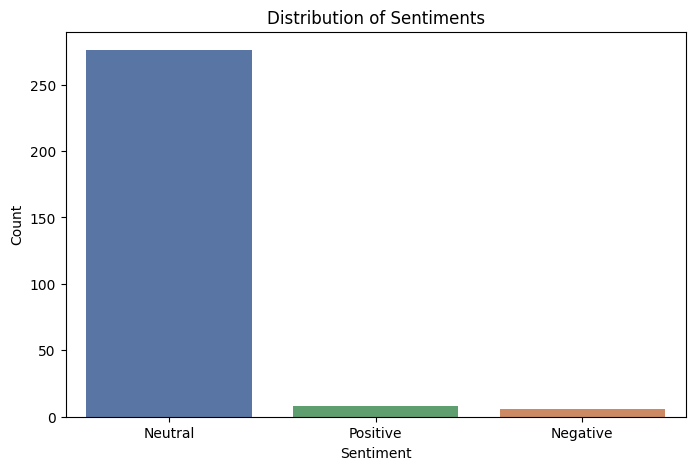

In [12]:
# Topic Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='topic', palette='viridis', hue='topic',order=data['topic'].value_counts().index)
plt.title("Distribution of Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.show()

# Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='sentiment', hue='sentiment',palette='deep', order=data['sentiment'].value_counts().index)
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [14]:
# Step 3: Train-Test Split
X_sentiment = data['cleaned_tweet']
y_sentiment = data['sentiment']
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X_sentiment, y_sentiment, test_size=0.2, stratify=y_sentiment, random_state=42)

X_topic = data['cleaned_tweet']
y_topic = data['topic']
X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(X_topic, y_topic, test_size=0.2, stratify=y_topic, random_state=42)

In [30]:
#Step 4: Feature Extraction

# Initialize LabelEncoder for sentiment and topic
label_encoder_sentiment = LabelEncoder()
label_encoder_topic = LabelEncoder()

# Encode sentiment labels (e.g., 'Positive', 'Negative', 'Neutral')
y_train_sentiment = label_encoder_sentiment.fit_transform(y_train_sentiment)
y_test_sentiment = label_encoder_sentiment.transform(y_test_sentiment)

# Encode topic labels (e.g., 'Healthcare', 'Economy', 'Education')
y_train_topic = label_encoder_topic.fit_transform(y_train_topic)
y_test_topic = label_encoder_topic.transform(y_test_topic)

# Fit and transform for Sentiment Classification
vectorizer = TfidfVectorizer(max_features=5000)
X_train_sentiment_tfidf = vectorizer.fit_transform(X_train_sentiment)
X_test_sentiment_tfidf = vectorizer.transform(X_test_sentiment)

# Transform for Topic Classification using the same vectorizer
X_train_topic_tfidf = vectorizer.transform(X_train_topic)
X_test_topic_tfidf = vectorizer.transform(X_test_topic)



Logistic Regression Classification Report for Sentiment:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.95      1.00      0.97        55
           2       0.00      0.00      0.00         2

    accuracy                           0.95        58
   macro avg       0.32      0.33      0.32        58
weighted avg       0.90      0.95      0.92        58


Logistic Regression Classification Report for Topic:

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       1.00      1.00      1.00         7
           3       0.90      1.00      0.95        36

    accuracy                           0.93        58
   macro avg       0.97      0.91      0.93        58
weighted avg       0.94      0.93      0.93        58



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


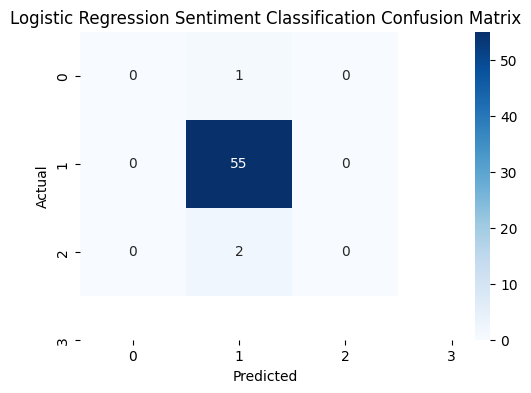

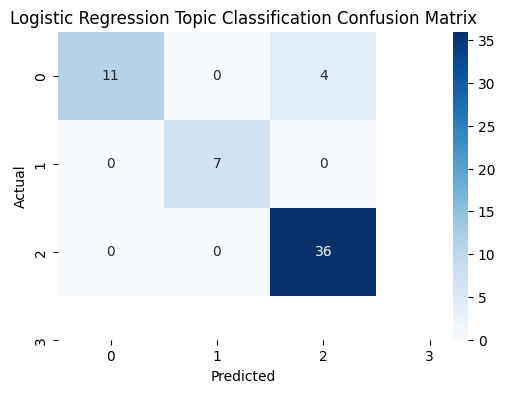


Random Forest Classification Report for Sentiment:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.96      1.00      0.98        55
           2       0.00      0.00      0.00         2

    accuracy                           0.97        58
   macro avg       0.65      0.67      0.66        58
weighted avg       0.93      0.97      0.95        58



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Classification Report for Topic:

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       1.00      1.00      1.00         7
           3       0.95      1.00      0.97        36

    accuracy                           0.97        58
   macro avg       0.98      0.96      0.97        58
weighted avg       0.97      0.97      0.96        58



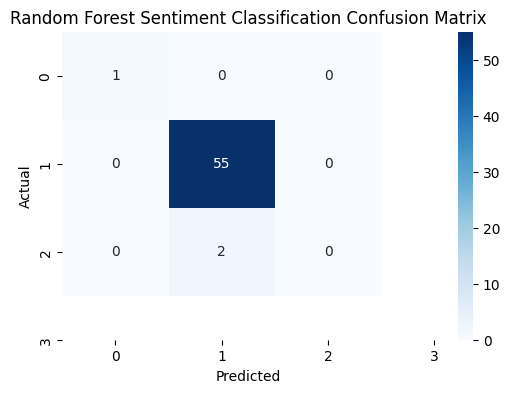

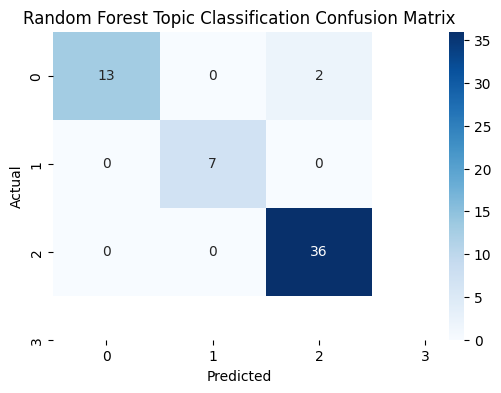


XGBoost Classification Report for Sentiment:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.98      0.98      0.98        55
           2       1.00      0.50      0.67         2

    accuracy                           0.97        58
   macro avg       0.83      0.83      0.77        58
weighted avg       0.97      0.97      0.97        58


XGBoost Classification Report for Topic:

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       1.00      1.00      1.00         7
           3       0.97      1.00      0.99        36

    accuracy                           0.98        58
   macro avg       0.99      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



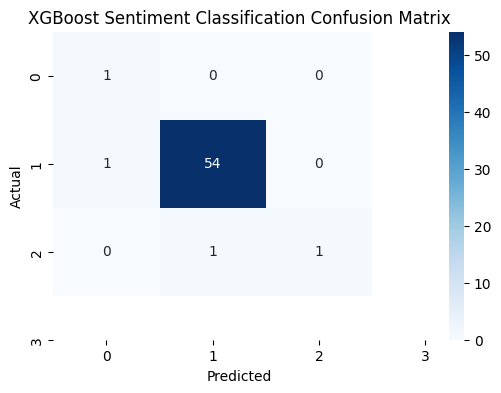

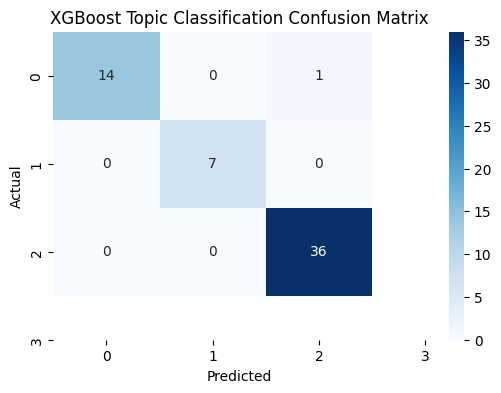

In [31]:
# Step 5: Model Development and Evaluation

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}

sentiment_results = []
topic_results = []

# Sentimenr Classification
for model_name, model in models.items():
    model.fit(X_train_sentiment_tfidf, y_train_sentiment)
    y_pred_sentiment = model.predict(X_test_sentiment_tfidf)
    acc_sentiment = accuracy_score(y_test_sentiment, y_pred_sentiment)
    f1_sentiment = f1_score(y_test_sentiment, y_pred_sentiment, average='weighted')
    sentiment_results.append({'Model': model_name, 'Accuracy': acc_sentiment, 'F1-Score': f1_sentiment})
    print(f"\n{model_name} Classification Report for Sentiment:\n")
    print(classification_report(y_test_sentiment, y_pred_sentiment))

    # Topic Classification
    model.fit(X_train_topic_tfidf, y_train_topic)
    y_pred_topic = model.predict(X_test_topic_tfidf)
    acc_topic = accuracy_score(y_test_topic, y_pred_topic)
    f1_topic = f1_score(y_test_topic, y_pred_topic, average='weighted')
    topic_results.append({'Model': model_name, 'Accuracy': acc_topic, 'F1-Score': f1_topic})
    print(f"\n{model_name} Classification Report for Topic:\n")
    print(classification_report(y_test_topic, y_pred_topic))

    # Confusion Matrix Heatmap
    cm_sentiment = confusion_matrix(y_test_sentiment, y_pred_sentiment)
    cm_topic = confusion_matrix(y_test_topic, y_pred_topic)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{model_name} Sentiment Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_topic, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'{model_name} Topic Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [36]:
# Hyperparameter Tuning (Random Forest)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search_sentiment = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted')
grid_search_sentiment.fit(X_train_sentiment_tfidf, y_train_sentiment)
print("Best Hyperparameters for Sentiment Classification (Random Forest):", grid_search_sentiment.best_params_)

param_grid_topic = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
grid_search_topic = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_topic, cv=3, scoring='f1_weighted')
grid_search_topic.fit(X_train_topic_tfidf, y_train_topic)
print("Best Hyperparameters for Topic Classification (Random Forest):", grid_search_topic.best_params_)

Best Hyperparameters for Sentiment Classification (Random Forest): {'max_depth': 10, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Hyperparameters for Topic Classification (Random Forest): {'max_depth': 20, 'n_estimators': 100}


In [37]:
# Tabulate Results and Bar Plots
print("\nSentiment Classification Performance Summary:")
print(tabulate(sentiment_results, headers="keys", tablefmt="grid"))
print("\nTopic Classification Performance Summary:")
print(tabulate(topic_results, headers="keys", tablefmt="grid"))


Sentiment Classification Performance Summary:
+---------------------+------------+------------+
| Model               |   Accuracy |   F1-Score |
+=====================+============+============+
| Logistic Regression |   0.948276 |   0.9231   |
+---------------------+------------+------------+
| Random Forest       |   0.965517 |   0.948584 |
+---------------------+------------+------------+
| XGBoost             |   0.965517 |   0.965517 |
+---------------------+------------+------------+

Topic Classification Performance Summary:
+---------------------+------------+------------+
| Model               |   Accuracy |   F1-Score |
+=====================+============+============+
| Logistic Regression |   0.931034 |   0.927544 |
+---------------------+------------+------------+
| Random Forest       |   0.965517 |   0.964752 |
+---------------------+------------+------------+
| XGBoost             |   0.982759 |   0.982579 |
+---------------------+------------+------------+


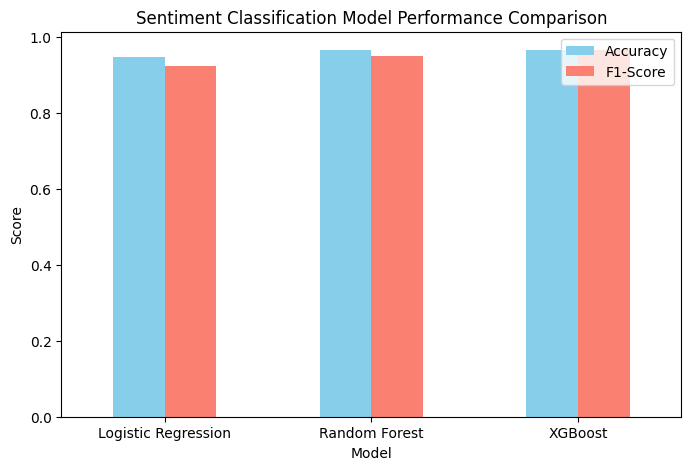

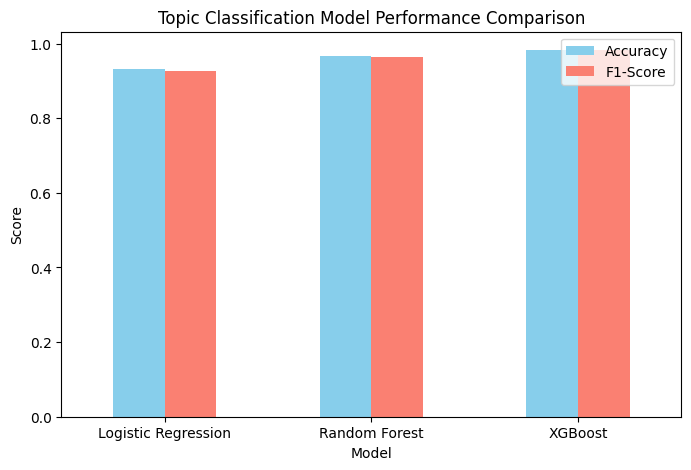

In [38]:
# Bar Plot for Sentiment Model Performance
sentiment_results_df = pd.DataFrame(sentiment_results)
sentiment_results_df.plot(x='Model', y=['Accuracy', 'F1-Score'], kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('Sentiment Classification Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Bar Plot for Topic Model Performance
topic_results_df = pd.DataFrame(topic_results)
topic_results_df.plot(x='Model', y=['Accuracy', 'F1-Score'], kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('Topic Classification Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

In [43]:
# Step 12: Save Outputs
data.to_csv('classified_data.csv', index=False)
print("\nClassified data saved as 'classified_data.csv'.")


Classified data saved as 'classified_data.csv'.


In [41]:
markdown_report = """
# Classification Model Report

## Key Findings:
- The dataset contains various tweets, which have been classified into sentiment (Positive, Negative, Neutral) and topics (Healthcare, Economy, Education, Other).
- The models used for classification are Logistic Regression, Random Forest, and XGBoost.
- XGBoost showing slightly higher accuracy and F1-Score across both sentiment and topic classification tasks.

"""